In [1]:
# Juan Pardo Palazon
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from pandas import read_csv
import pandas as pd 
import numpy as np
import os

In [2]:
# Constantes
NUM_WEEK = 5
DECIMALES = 2
fileBase = 'Hogar_' 
fileTailWeek = '_filtro_semanal_rango.csv'
RUTA_ACTUAL = os.path.dirname(os.path.realpath('__file__'))
DIRECTORIO_GUARDADO_IMG = 'IMG_PRED'
houseTotal = list()

In [3]:
def getFinalARModel(series):
    X = series.values
    # Entrenar modelo AR
    model = AR(X)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    return window,coef,model_fit

In [4]:
def predictionAR(model_fit, data):
    predictions = model_fit.predict(start=len(data), end=len(data)+NUM_WEEK-1, dynamic=False)
    return predictions

In [5]:
def getPrediction(df):
    
    house = list()
    # train,test,window,coef,model_fit
    predictionGroup = list()
    
    series = df['Rango 00-06']
    window,coef,model_fit = getFinalARModel(series)
    predictions=predictionAR(model_fit, series)
    predictionGroup.append(predictions)
    
    series = df['Rango 06-12']
    window,coef,model_fit = getFinalARModel(series)
    predictions=predictionAR(model_fit, series)
    predictionGroup.append(predictions)
    
    series = df['Rango 12-18']
    window,coef,model_fit = getFinalARModel(series)
    predictions=predictionAR(model_fit, series)
    predictionGroup.append(predictions)
    
    series = df['Rango 18-00']
    window,coef,model_fit = getFinalARModel(series)
    predictions=predictionAR(model_fit, series)
    house.append(predictions[0])  
    
    predictionGroup.append(predictions)
    
    return predictionGroup

In [6]:
# Filtrar por fechas dadas y seleccionar columna consumo total (Aggregate)
def mostrarGrafico(to_plot, num_hogar):
    # Mostrar gráfica
    grafico_interpolado = to_plot.interpolate(method='spline', order=2)
    plot = grafico_interpolado.plot()
    pyplot.title('Previsión mensual. Hogar ' + num_hogar)
    pyplot.ylabel('Consumo de energía')
    pyplot.xticks(np.arange(5), ('Semana+1', 'Semana+2', 'Semana+3', 'Semana+4', 'Semana+5'))
    pyplot.show()
    
    # Se recoge la gráfica y se guarda en un fichero png
    fichero = os.path.join(RUTA_ACTUAL, DIRECTORIO_GUARDADO_IMG, 'Hogar_' + num_hogar + '_Prediccion.png')
    figura = plot.get_figure()
    figura.savefig(fichero)

In [7]:
def generarFicheroPrediccion(df, num_hogar):
    df_prediccion = pd.DataFrame(df).apply(lambda x: round(x, DECIMALES))
    df_prediccion.index.name = 'Semanas'
    df_prediccion.to_csv('Hogar_' + str(num_hogar) + '_prediccion.csv', sep=',', encoding='utf-8')

In [8]:
def mostrarPrediccion(df, num_hogar):
    predictions = getPrediction(df)
    dfPredict = pd.DataFrame(predictions)
    # Transponer la tabla
    dfPredict = dfPredict.T
    dfPredict.columns = ['Rango 00-06','Rango 06-12','Rango 12-18','Rango 18-00']
    mostrarGrafico(dfPredict, num_hogar)
    generarFicheroPrediccion(dfPredict, num_hogar)

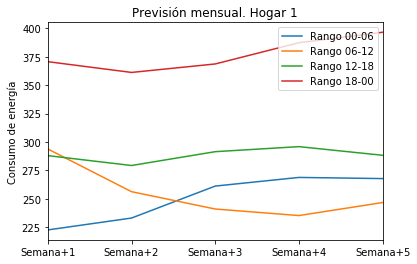

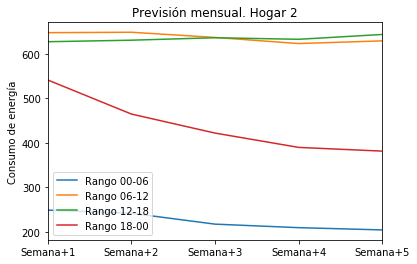

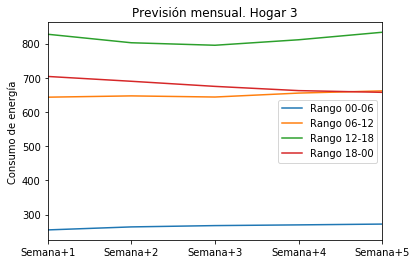

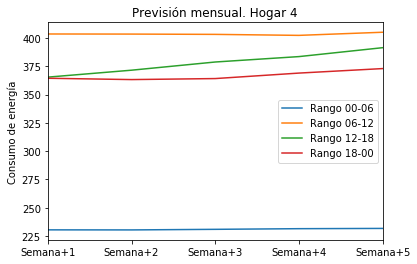

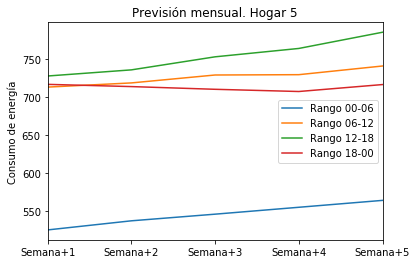

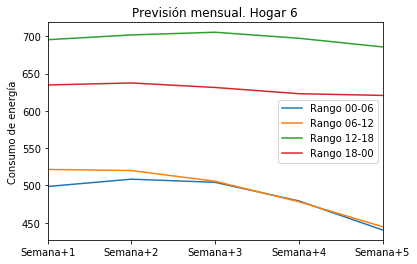

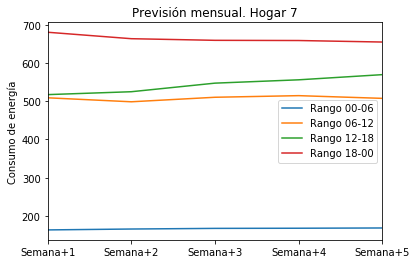

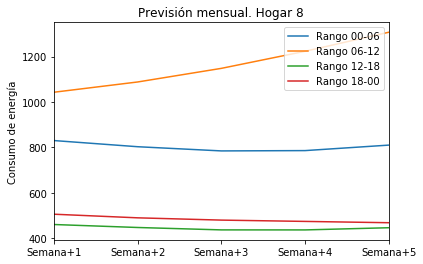

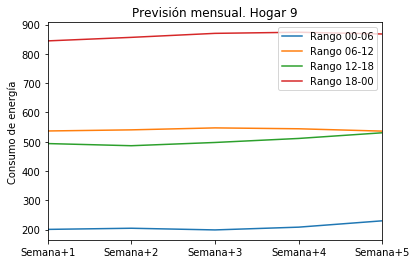

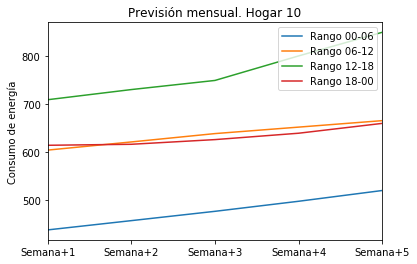

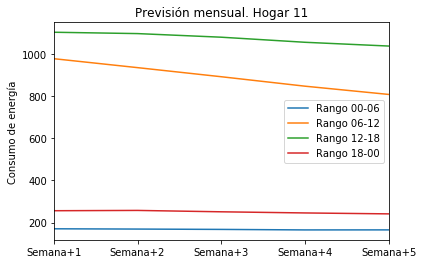

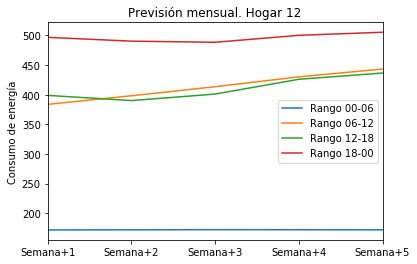

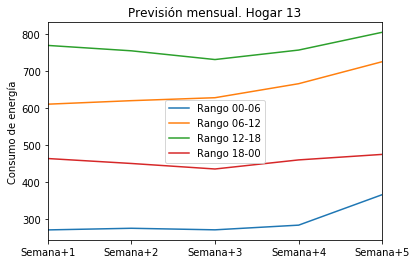

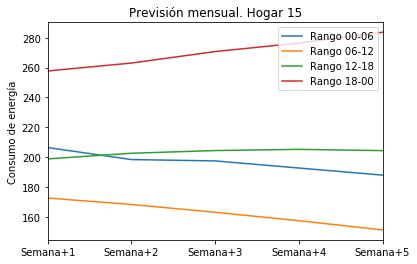

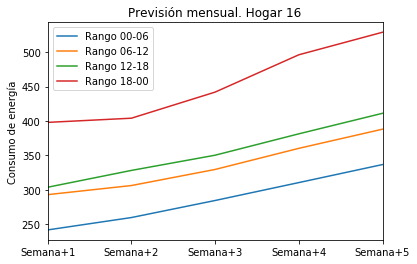

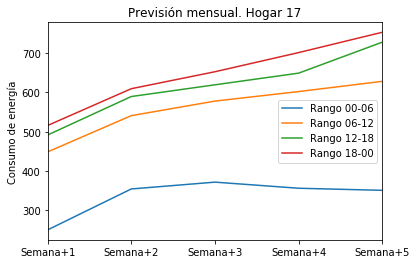

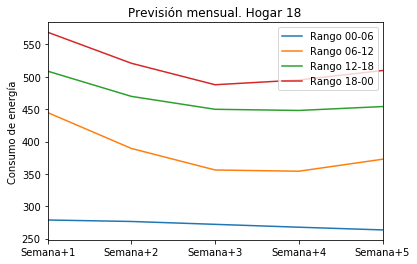

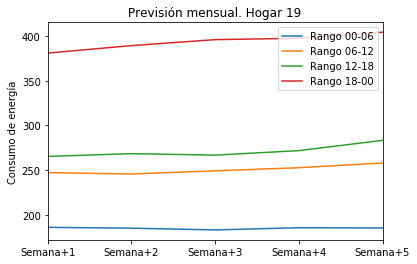

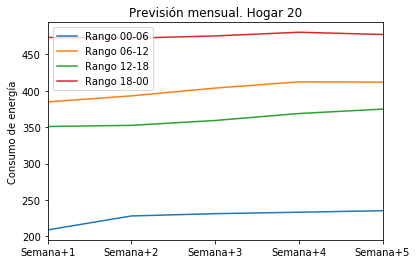

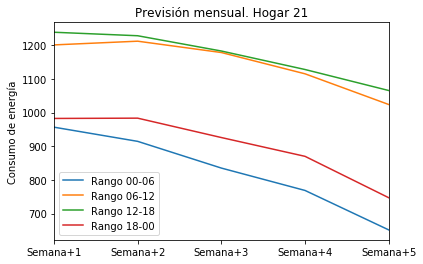

In [9]:
for num_hogar in range(1, 22):
    if num_hogar != 14:
        fichero = fileBase + str(num_hogar) + fileTailWeek
        df = read_csv(fichero, delimiter = ',', parse_dates=[0], index_col=0)
        mostrarPrediccion(df, str(num_hogar))